# Figure: model comparison

https://github.com/nlx-group/WordNetEmbeddings?tab=readme-ov-file

Saedi, Chakaveh, António Branco, João António Rodrigues and João Ricardo Silva, 2018, "WordNet Embeddings", In Proceedings, 3rd Workshop on Representation Learning for Natural Language Processing (RepL4NLP), 56th Annual Meeting of the Association for Computational Linguistics, 15-20 July 2018, Melbourne, Australia.

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests
from scipy import stats
from himalaya.scoring import correlation_score

from util import plot, subject
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [4]:
encmodel = "encoding_trialmot6"
cache = encmodel.split("_")[-1]
encmodel, cache

('encoding_trialmot6', 'trialmot6')

In [8]:
cachedir = f"cache/figure3-mbc/{cache}/"
!mkdir -p $cachedir

In [3]:
fgmask = get_brainmask()


def ttest_sig(
    values: np.ndarray,
    popmean: int = 0,
    correlations: bool = True,
    alternative: str = "two-sided",
    alpha: float = 0.01,
    method="bonf",
):
    if correlations:
        values = np.arctanh(values)

    ttest = stats.ttest_1samp(values, popmean=popmean, alternative=alternative)

    pvalues = ttest.pvalue
    multiple = multipletests(pvalues[fgmask], alpha=alpha, method=method)

    reject = np.zeros_like(pvalues, dtype=bool)
    reject[*fgmask.nonzero()] = multiple[0]

    return reject

In [5]:
models = ['acoustic', 'articulatory', 'syntactic', 'static', 'contextual']

# within-subject encoding comparison

In [20]:
results = defaultdict(list)
for modelname in models:
    respath = Path(
        root=encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in tqdm(SUBS_STRANGERS, desc=modelname):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", sub)
            continue
        with h5py.File(respath, "r") as f:
            results[modelname].append(np.mean(f['cv_scores_prod'][:, -2] + f['cv_scores_comp'][:, -1], axis=0))
            # for key in ["cv_scores_prod", "cv_scores_comp"]:  # , "cv_scores"]:
            #     # all_results[(modelname, key)].append(f[key][...])
            #     results[key].append(f[key][...])

for modelname in models:
    results[modelname] = np.stack(results[modelname])

contextual: 100%|██████████| 58/58 [00:02<00:00, 26.43it/s]


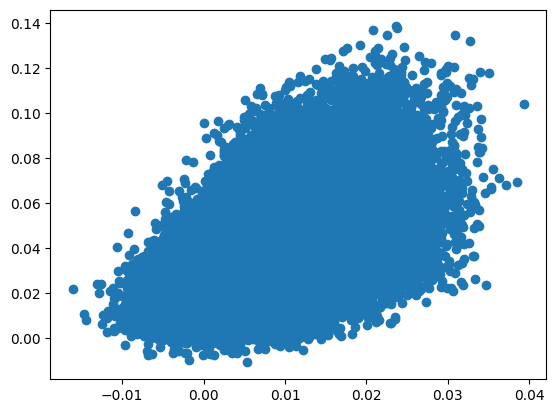

In [36]:
plt.scatter(results['syntactic'].mean(0), results['articulatory'].mean(0))

acoustic 0.031576604 0.07340537
articulatory 0.02980056 0.06702406
syntactic 0.025036706 0.025036706
static 0.027404167 0.05752295
contextual 0.035004154 0.10873678


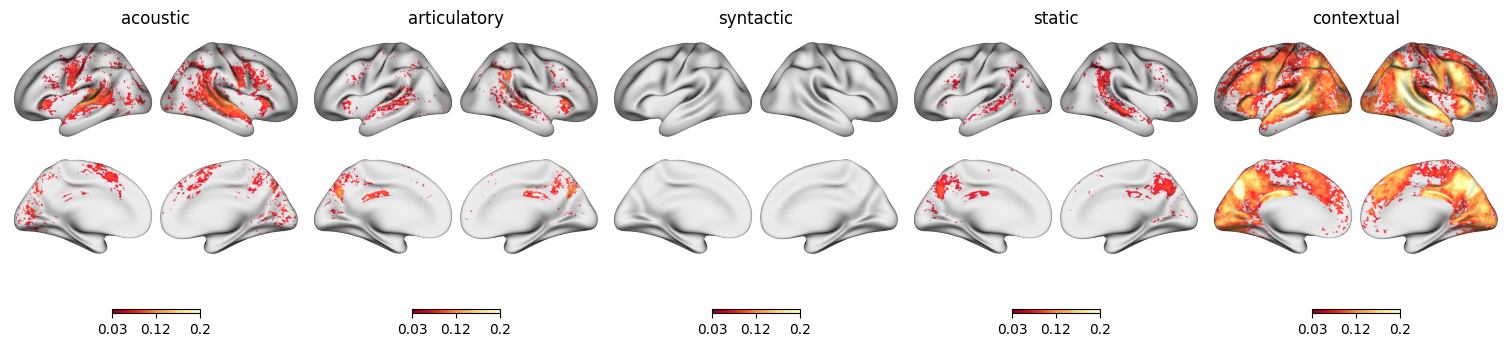

In [39]:
fig, axes = plt.subplots(1, len(models), figsize=(15, 6), layout='constrained')

for modelname, ax in zip(models, axes):
    sigmask = ~ ttest_sig(results[modelname], method='bonf', alpha=0.05)
    values = results[modelname].mean(0)
    min = values[~sigmask].min()
    print(modelname, min, values[~sigmask].mean())
    min = .03
    plot.surface_plot(values, threshold=sigmask, fig=fig, ax=ax, vmin=min, vmax=0.2, cmap="YlOrRd_r", title=modelname)

fig.show()

# MBC comparison

In [6]:
def get_mbc(modelname:str):
    mbc_scores = defaultdict(list)

    # use subA's predictions on subB's actual neural data
    for subA in tqdm(SUBS_STRANGERS):
        # load subA preds
        encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            Y_predsA = f["cv_preds"][...]  # (5, 6, 240, 81924)
            prod_predA = Y_predsA[:, -2].reshape(1200, -1)
            comp_predA = Y_predsA[:, -1].reshape(1200, -1)
            prodmaskA = f["cv_prodmask"][...].ravel()
        
        # load subB preds
        subB = subject.get_partner(subA)
        encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            Y_predsB = f["cv_preds"][...]  # (5, 6, 240, 81924)
            nuis_predsB = Y_predsB[:, :-2].sum(1).reshape(1200, -1)

        dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
        resB = dataB - nuis_predsB
        compmaskA = ~prodmaskA

        for i in range(0, 1200, 240):
            trial_slc = slice(i, i + 240)
            mbc_scores["prod"].append( correlation_score(prod_predA[trial_slc][prodmaskA[trial_slc]], resB[trial_slc][prodmaskA[trial_slc]]))
            mbc_scores["comp"].append( correlation_score(comp_predA[trial_slc][compmaskA[trial_slc]], resB[trial_slc][compmaskA[trial_slc]]))

    sub_mbc_prod = np.stack(mbc_scores["prod"])
    sub_mbc_comp = np.stack(mbc_scores["comp"])
    
    return sub_mbc_prod, sub_mbc_comp

In [7]:
results = []
for modelname in tqdm(models):
    results.append(get_mbc(modelname))

100%|██████████| 5/5 [1:03:42<00:00, 764.40s/it]


In [9]:
# save
with h5py.File(f"{cachedir}/mbc-between.hdf5", "w") as f:
    for modelname, (prod, comp) in zip(models, results):
        f.create_dataset(name=f'{modelname}_prod', data=prod)
        f.create_dataset(name=f'{modelname}_comp', data=comp)

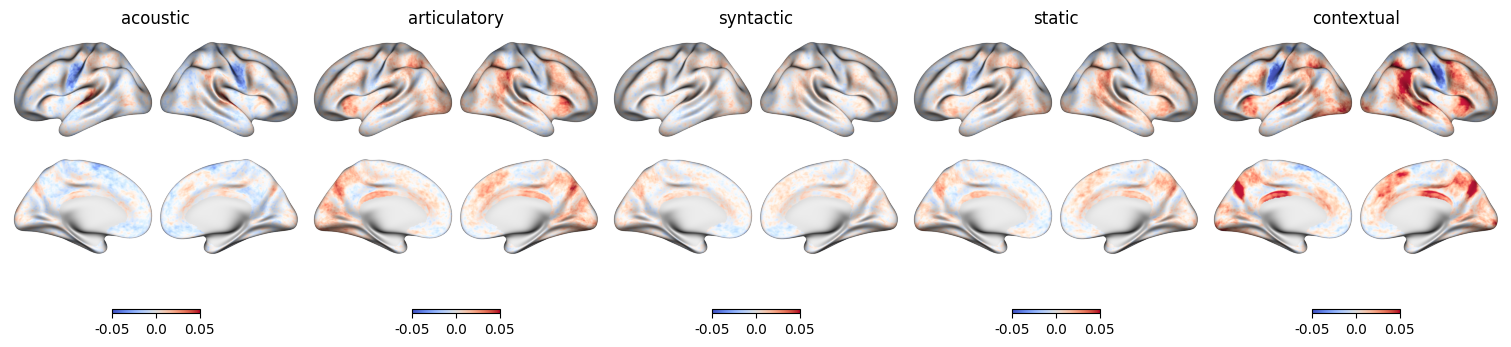

In [19]:
fig, axes = plt.subplots(1, len(models), figsize=(15, 6), layout='constrained')

for modelname, result, ax in zip(models, results, axes):
    # sigmask = ~ ttest_sig(results[modelname], method='bonf', alpha=0.05)
    values = (result[0] + result[1]) / 2
    plot.surface_plot(values.mean(0), fig=fig, ax=ax, vmax=0.05, cmap="coolwarm", title=modelname)

fig.show()